In [33]:
from PIL import Image

In [34]:
METAFILE_DIR = "./dataset/metafiles/"
OUTPUT_DIR = "./dataset/masks/gt/"

In [35]:
# get image's widths and heights
with open(METAFILE_DIR + "widths_heights.txt", "r") as f:
    lines = f.readlines()

w2hs = []
for line in lines:
    parts = line.strip().split(" ")
    w2hs.append([int(parts[1]), int(parts[2])])

f.close()

items_length = len(w2hs)

In [36]:
# get partial masks
with open(METAFILE_DIR + "part_locs.txt", "r") as f:
    lines = f.readlines()

mask_coords = []

for line in lines:
    mask_coord = {}
    parts = line.strip().split(" ")
    mask_coord["id"] = int(parts[0])
    mask_coord["part"] = int(parts[1])
    mask_coord["rle"] = [int(x) for x in parts[2:]]
    mask_coords.append(mask_coord)

f.close()

In [37]:
# get image id and its name
with open(METAFILE_DIR + "images.txt", "r") as f:
    lines = f.readlines()

img_names = []
for line in lines:
    parts = line.strip().split(" ")
    img_names.append(parts[1])

f.close()


In [38]:
from typing import List
import numpy as np


class InputStream:
    def __init__(self, data):
        self.data = data
        self.i = 0

    def read(self, size):
        out = self.data[self.i : self.i + size]
        self.i += size
        return int(out, 2)


def access_bit(data, num):
    """from bytes array to bits by num position"""
    base = int(num // 8)
    shift = 7 - int(num % 8)
    return (data[base] & (1 << shift)) >> shift


def bytes2bit(data):
    """get bit string from bytes data"""
    return "".join([str(access_bit(data, i)) for i in range(len(data) * 8)])


def rle_to_mask(rle: List[int], height: int, width: int) -> np.array:
    """
    Converts rle to image mask
    Args:
        rle: your long rle
        height: original_height
        width: original_width

    Returns: np.array
    """

    rle_input = InputStream(bytes2bit(rle))

    num = rle_input.read(32)
    word_size = rle_input.read(5) + 1
    rle_sizes = [rle_input.read(4) + 1 for _ in range(4)]
    # print('RLE params:', num, 'values,', word_size, 'word_size,', rle_sizes, 'rle_sizes')

    i = 0
    out = np.zeros(num, dtype=np.uint8)
    while i < num:
        x = rle_input.read(1)
        j = i + 1 + rle_input.read(rle_sizes[rle_input.read(2)])
        if x:
            val = rle_input.read(word_size)
            out[i:j] = val
            i = j
        else:
            while i < j:
                val = rle_input.read(word_size)
                out[i] = val
                i += 1

    image = np.reshape(out, [height, width, 4])[:, :, 3]
    return image

In [39]:
import numpy as np


# combine 3 parts as a whole mask
def getMask(id: int):
    # mask = np.zeros(w2hs[id-1])
    mask_parts = []
    for i in range(0, 3):
        mask_parts.append(rle_to_mask(mask_coords[id * 3 - 3 + i]["rle"], w2hs[id - 1][1], w2hs[id - 1][0]))
        # mask = mask | mask_part
    mask = mask_parts[0] | mask_parts[1]
    mask = mask | mask_parts[2]
    mask = np.where(mask > 0, 1, 0)

    return mask

In [40]:
import numpy as np

mask = getMask(5)
print(mask.shape)
print(w2hs[149])

mask = np.where(mask > 0, 1, 0)

(458, 500)
[500, 333]


In [41]:
mask[147][137]


1

In [42]:
def convertPNG(id: int):
    mask = getMask(id)
    img_name = img_names[id - 1]
    png = Image.new("1", (w2hs[id - 1][0], w2hs[id - 1][1]))
    pixels = png.load()
    for i in range(png.size[0]):
        for j in range(png.size[1]):
            pixels[i, j] = int(mask[j][i])

    # png.show()
    png.save(OUTPUT_DIR + img_name)

In [28]:
# save all masks to masks_gt folder
for img_id in range(items_length):
    img_id = img_id + 1
    mask = getMask(img_id)
    png = convertPNG(img_id)
    print("Progress: \t" + str((img_id + 1)) + "/" + str(items_length), end="\r")

print("FINISHED!")


FINISHED! 	727/726


In [31]:
convertPNG(5)


In [45]:
mask_t = plt.imread("./dataset/masks/gt/" + img_names[img_id - 1])


In [46]:
mask_t[147]


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  13,   0,
        12,  19,   0,   0,   0,  17,  20, 253, 249, 250, 241, 255, 252,
       253, 241, 255, 243, 250, 252,   0,   0,   8,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

[500, 458]


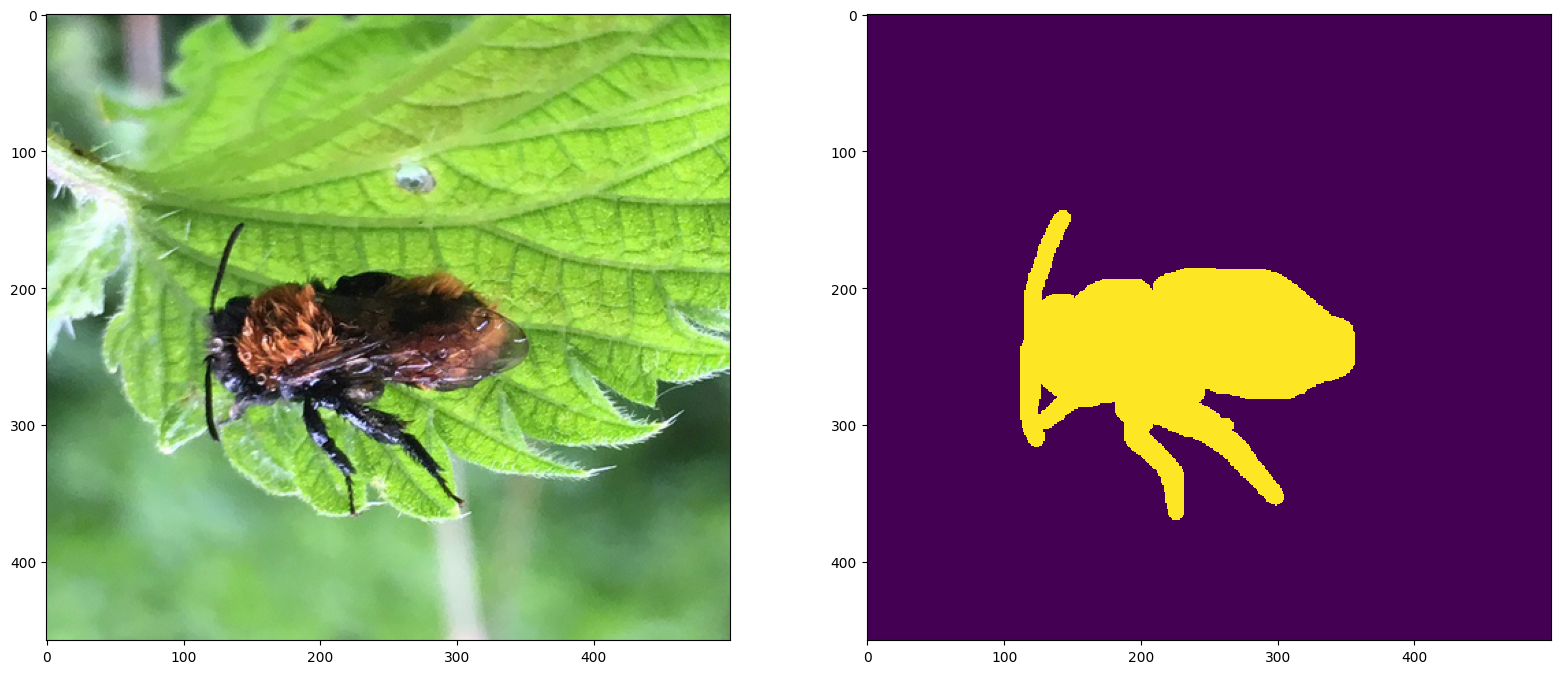

In [43]:
import matplotlib.pyplot as plt

img_id = 5
img_origin = plt.imread("./dataset/WildBees/" + img_names[img_id - 1])
# mask_png = plt.imread("./dataset/masks_gt/" + img_names[img_id - 1])
mask = getMask(img_id)
# png = convertPNG(img_id)
print(w2hs[img_id - 1])

plt.figure(figsize=(30, 20))

plt.subplot(1, 3, 1)
plt.imshow(img_origin)
plt.subplot(1, 3, 2)
plt.imshow(mask, interpolation="none")
# plt.subplot(1, 3, 3)
# plt.imshow(mask_png, interpolation="none")

plt.show()
